c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Estatísticas descritivas das vendas:
   vendas_minimas  vendas_maximas  vendas_medias  vendas_totais  total_vendas
0               0             763       1.126352       65727394      58354236


c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


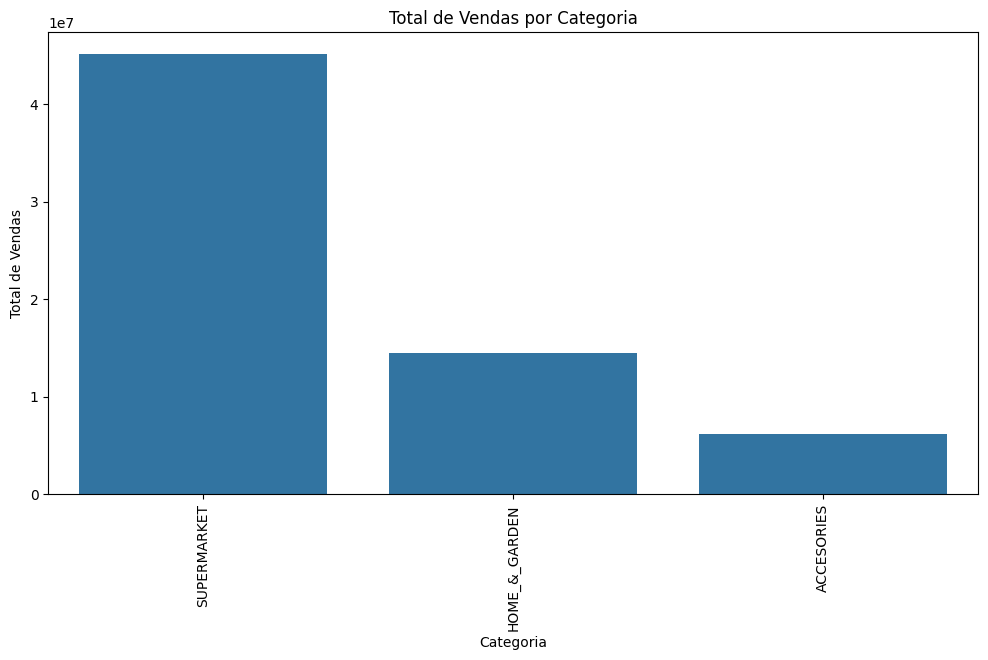

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


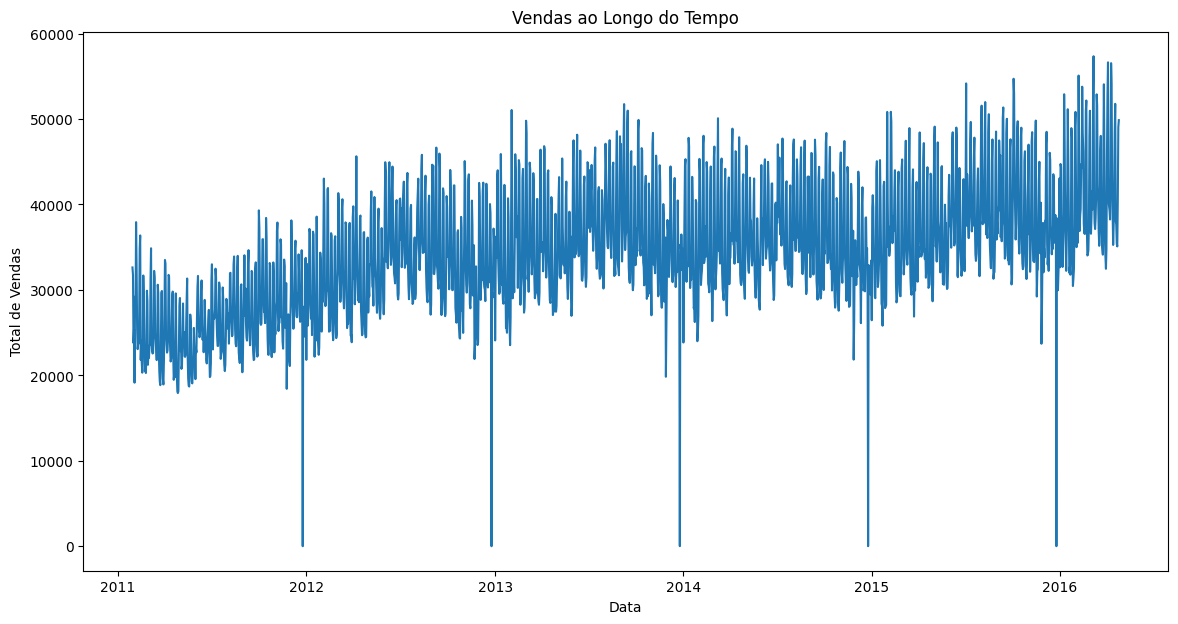

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


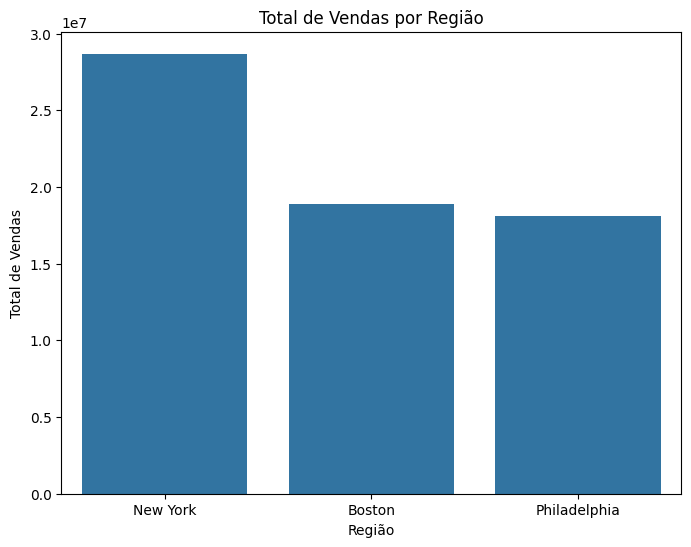

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


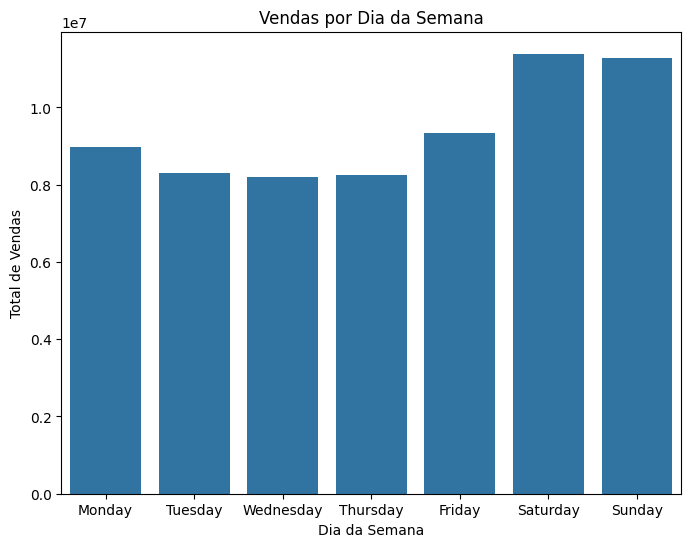

c:\Users\rpiaz\Desenvolvimento\DSMarket\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


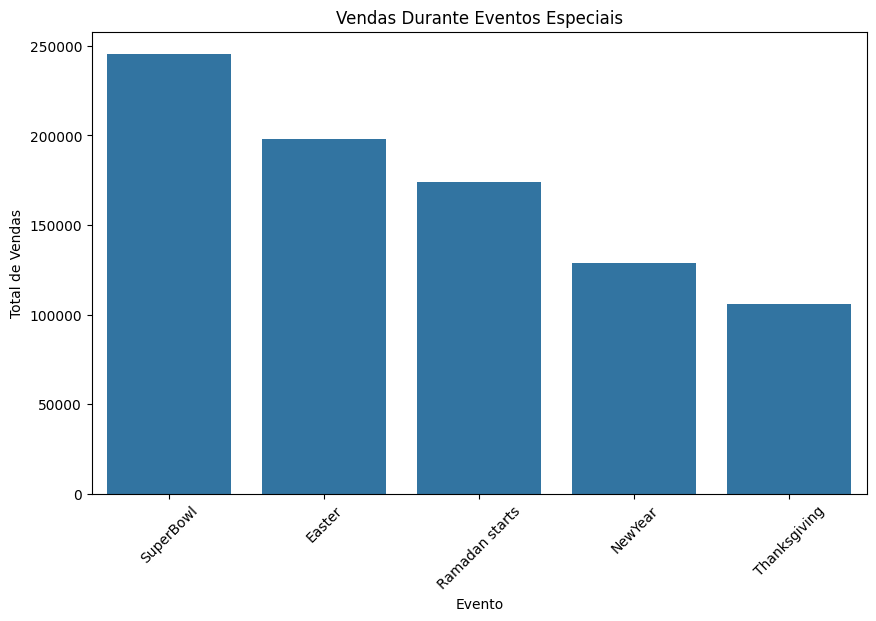

In [5]:
# Importar bibliotecas necessárias
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar credenciais e cliente BigQuery
service_account_path = 'tfm-sa.json'  # Substitua pelo caminho correto para o seu arquivo de credenciais
credentials = service_account.Credentials.from_service_account_file(service_account_path)
project_id = 'perseverance-332400'
client = bigquery.Client(credentials=credentials, project=project_id)

# Consulta SQL para obter estatísticas descritivas das vendas
query_stats = """
SELECT
    MIN(sales) AS vendas_minimas,
    MAX(sales) AS vendas_maximas,
    AVG(sales) AS vendas_medias,
    SUM(sales) AS vendas_totais,
    COUNT(sales) AS total_vendas
FROM `perseverance-332400.TFM.ds_market`
"""

# Executar a consulta e carregar os resultados em um DataFrame
df_stats = client.query(query_stats).to_dataframe()
print("Estatísticas descritivas das vendas:")
print(df_stats)

# Consulta SQL para vendas por categoria
query_category = """
SELECT category_x, SUM(sales) AS total_vendas
FROM `perseverance-332400.TFM.ds_market`
GROUP BY category_x
ORDER BY total_vendas DESC
"""

df_category = client.query(query_category).to_dataframe()

# Plotar gráfico de vendas por categoria
plt.figure(figsize=(12,6))
sns.barplot(x='category_x', y='total_vendas', data=df_category)
plt.title('Total de Vendas por Categoria')
plt.xlabel('Categoria')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=90)
plt.show()

# Consulta SQL para vendas ao longo do tempo
query_time = """
SELECT date, SUM(sales) AS total_vendas
FROM `perseverance-332400.TFM.ds_market`
GROUP BY date
ORDER BY date
"""

df_time = client.query(query_time).to_dataframe()
df_time['date'] = pd.to_datetime(df_time['date'])

# Plotar gráfico de vendas ao longo do tempo
plt.figure(figsize=(14,7))
plt.plot(df_time['date'], df_time['total_vendas'])
plt.title('Vendas ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Total de Vendas')
plt.show()

# Consulta SQL para vendas por região
query_region = """
SELECT region, SUM(sales) AS total_vendas
FROM `perseverance-332400.TFM.ds_market`
GROUP BY region
ORDER BY total_vendas DESC
"""

df_region = client.query(query_region).to_dataframe()

# Plotar gráfico de vendas por região
plt.figure(figsize=(8,6))
sns.barplot(x='region', y='total_vendas', data=df_region)
plt.title('Total de Vendas por Região')
plt.xlabel('Região')
plt.ylabel('Total de Vendas')
plt.show()

# Consulta SQL para vendas por dia da semana
query_weekday = """
SELECT
  FORMAT_DATE('%A', date) AS dia_semana,
  SUM(sales) AS total_vendas
FROM `perseverance-332400.TFM.ds_market`
GROUP BY dia_semana
"""

df_weekday = client.query(query_weekday).to_dataframe()

# Ordenar dias da semana
dias_ordem = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_weekday['dia_semana'] = pd.Categorical(df_weekday['dia_semana'], categories=dias_ordem, ordered=True)
df_weekday = df_weekday.sort_values('dia_semana')

# Plotar gráfico de vendas por dia da semana
plt.figure(figsize=(8,6))
sns.barplot(x='dia_semana', y='total_vendas', data=df_weekday)
plt.title('Vendas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Total de Vendas')
plt.show()

# Consulta SQL para impacto de eventos nas vendas
query_events = """
SELECT event, SUM(sales) AS total_vendas
FROM `perseverance-332400.TFM.ds_market`
WHERE event IS NOT NULL
GROUP BY event
ORDER BY total_vendas DESC
"""

df_events = client.query(query_events).to_dataframe()

# Plotar gráfico de vendas por eventos
plt.figure(figsize=(10,6))
sns.barplot(x='event', y='total_vendas', data=df_events)
plt.title('Vendas Durante Eventos Especiais')
plt.xlabel('Evento')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=45)
plt.show()
